In [1]:
import torch
import torchvision
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from diffusers import DDPMScheduler, UNet2DModel
from matplotlib import pyplot as plt
import cv2
import numpy as np


device = torch.device("mps") if torch.backends.mps.is_available() else torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

print("Opencv version:",cv2.__version__)
print(f"Using device: {device}")

/Users/wenbo/anaconda3/envs/DiffusionModel/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Opencv version: 4.10.0
Using device: mps


## Lets capture a photo for ourselves

In [2]:
# import time
# cap = cv2.VideoCapture(0)
# if not cap.isOpened():
#     print("Error: Could not open the camera.")
#     exit()
# time.sleep(2)
# ret, frame = cap.read()
# if ret:
#     # Save the photo to a file without showing a window
#     photo_path = "captured_photo.jpg"
#     cv2.imwrite(photo_path, frame)
#     print(f"Photo saved as {photo_path}")
# else:
#     print("Error: Could not capture a frame.")
# cap.release()

### Use YOLO model to detect a person and crop the person


image 1/1 /Users/wenbo/OntarioTech/CSCI 4052U Machine Learning 2/HandsOn-from-basic-encoder_decoder-to-stable-diffusion/captured_photo.jpg: 384x640 1 person, 39.7ms
Speed: 1.8ms preprocess, 39.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)


/Users/wenbo/anaconda3/envs/DiffusionModel/lib/python3.10/site-packages/ultralytics/nn/tasks.py:634: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return torch.load(file, ma

Detected a person at [[     560.13      323.29      1544.6      1072.8]]


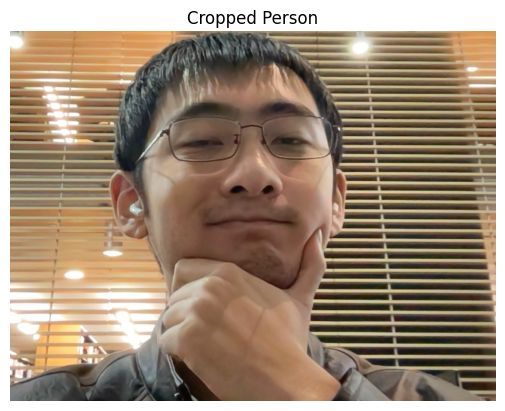

Cropped image saved at cropped_person.jpg


In [3]:
from ultralytics import YOLO
# Load a pretrained YOLO model (recommended for training)
yolo_model = YOLO("yolov8n.pt")
# Path to your image
image_path = 'captured_photo.jpg'
# Perform person detection
results = yolo_model(image_path)

image_orig = cv2.imread(image_path)
# Convert the image from BGR to RGB for displaying with matplotlib
image_rgb = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
# Display and save results
for result in results:
    # Boxes contain coordinates for detected objects
    boxes = result.boxes
    for box in boxes:
        if box.cls == 0:  # Class ID for 'person' in COCO dataset
            print(f"Detected a person at {box.xyxy.cpu().numpy()}")  # Bounding box coordinates
            bbox = box.xyxy[0].cpu().numpy()
            bbox = [int(coord) for coord in bbox]
            cropped_image = image_rgb[bbox[1]:bbox[3], bbox[0]:bbox[2]]
            
            # Display the cropped image using matplotlib
            plt.imshow(cropped_image)
            plt.axis('off')  # Hide axis
            plt.title("Cropped Person")
            plt.show()
            
            # Save the cropped image if needed
            cropped_image_path = "cropped_person.jpg"
            cropped_image_bgr = cv2.cvtColor(cropped_image, cv2.COLOR_RGB2BGR)  # Convert back to BGR for saving
            cv2.imwrite(cropped_image_path, cropped_image_bgr)
            print(f"Cropped image saved at {cropped_image_path}")


## Add Noise

In [4]:
# Read cropped image

image_orig = cv2.imread("cropped_person.jpg")
image_rgb = cv2.cvtColor(image_orig, cv2.COLOR_BGR2RGB)
# plt.imshow(image_rgb)

## Define add noise Function

In [5]:
def add_noise(x, amount):
    """Corrupt the input `x` by mixing it with noise according to `amount`"""
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)  # Adjust shape for batch processing
    noised_img = x * (1 - amount) + noise * amount
    return noised_img, noise

/var/folders/pm/x83zrlkn551fhsmr72ncx8yw0000gn/T/ipykernel_80779/867354943.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:281.)
  image_batch = torch.tensor([image_rgb for i in range(0,8)])
/var/folders/pm/x83zrlkn551fhsmr72ncx8yw0000gn/T/ipykernel_80779/867354943.py:2: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image_batch = torch.tensor(image_batch, dtype=torch.float32) / 255.0


Amount noise added to the oroginal picture: tensor([0.0000, 0.1429, 0.2857, 0.4286, 0.5714, 0.7143, 0.8571, 1.0000])
torch.Size([8, 749, 984, 3])


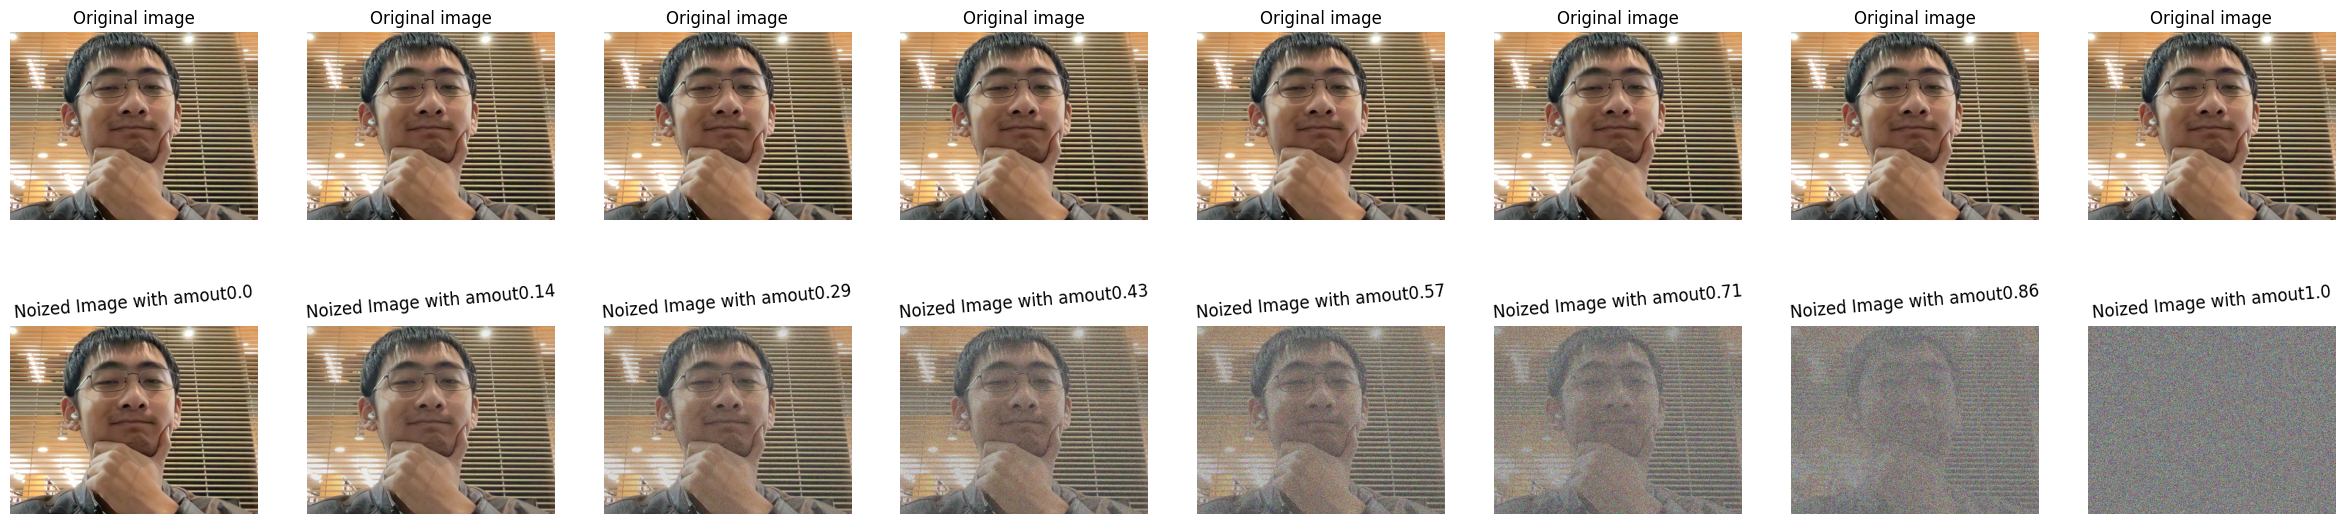

In [6]:
image_batch = torch.tensor([image_rgb for i in range(0,8)])
image_batch = torch.tensor(image_batch, dtype=torch.float32) / 255.0

amount = torch.linspace(0, 1, image_batch.shape[0])  # Left to right -> more corruption
print("Amount noise added to the oroginal picture:", amount)
print(image_batch.shape)

noised_img, noise = add_noise(image_batch, amount)

plt.figure(figsize=(30, 7))
for i in range(0, 16):
    plt.subplot(2, 8, i+1)
    if i < 8:
        plt.imshow(image_batch[i])
        plt.title("Original image")
        plt.axis('off')
    else:
        plt.imshow(noised_img[i-8])
        plt.title("Noized Image with amout" + str(round(amount[i-8].item(), 2)), rotation=5)
        plt.axis('off')

plt.show()

## Denoise

In [7]:
def denoise(corrupted_x, amount, noise):
    """Reconstruct the original input `x` from the corrupted version"""
    amount = amount.view(-1, 1, 1, 1)  # Adjust shape for batch processing
    original_x = (corrupted_x - noise * amount) / (1 - amount)
    return original_x

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000001].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..1.0000002].


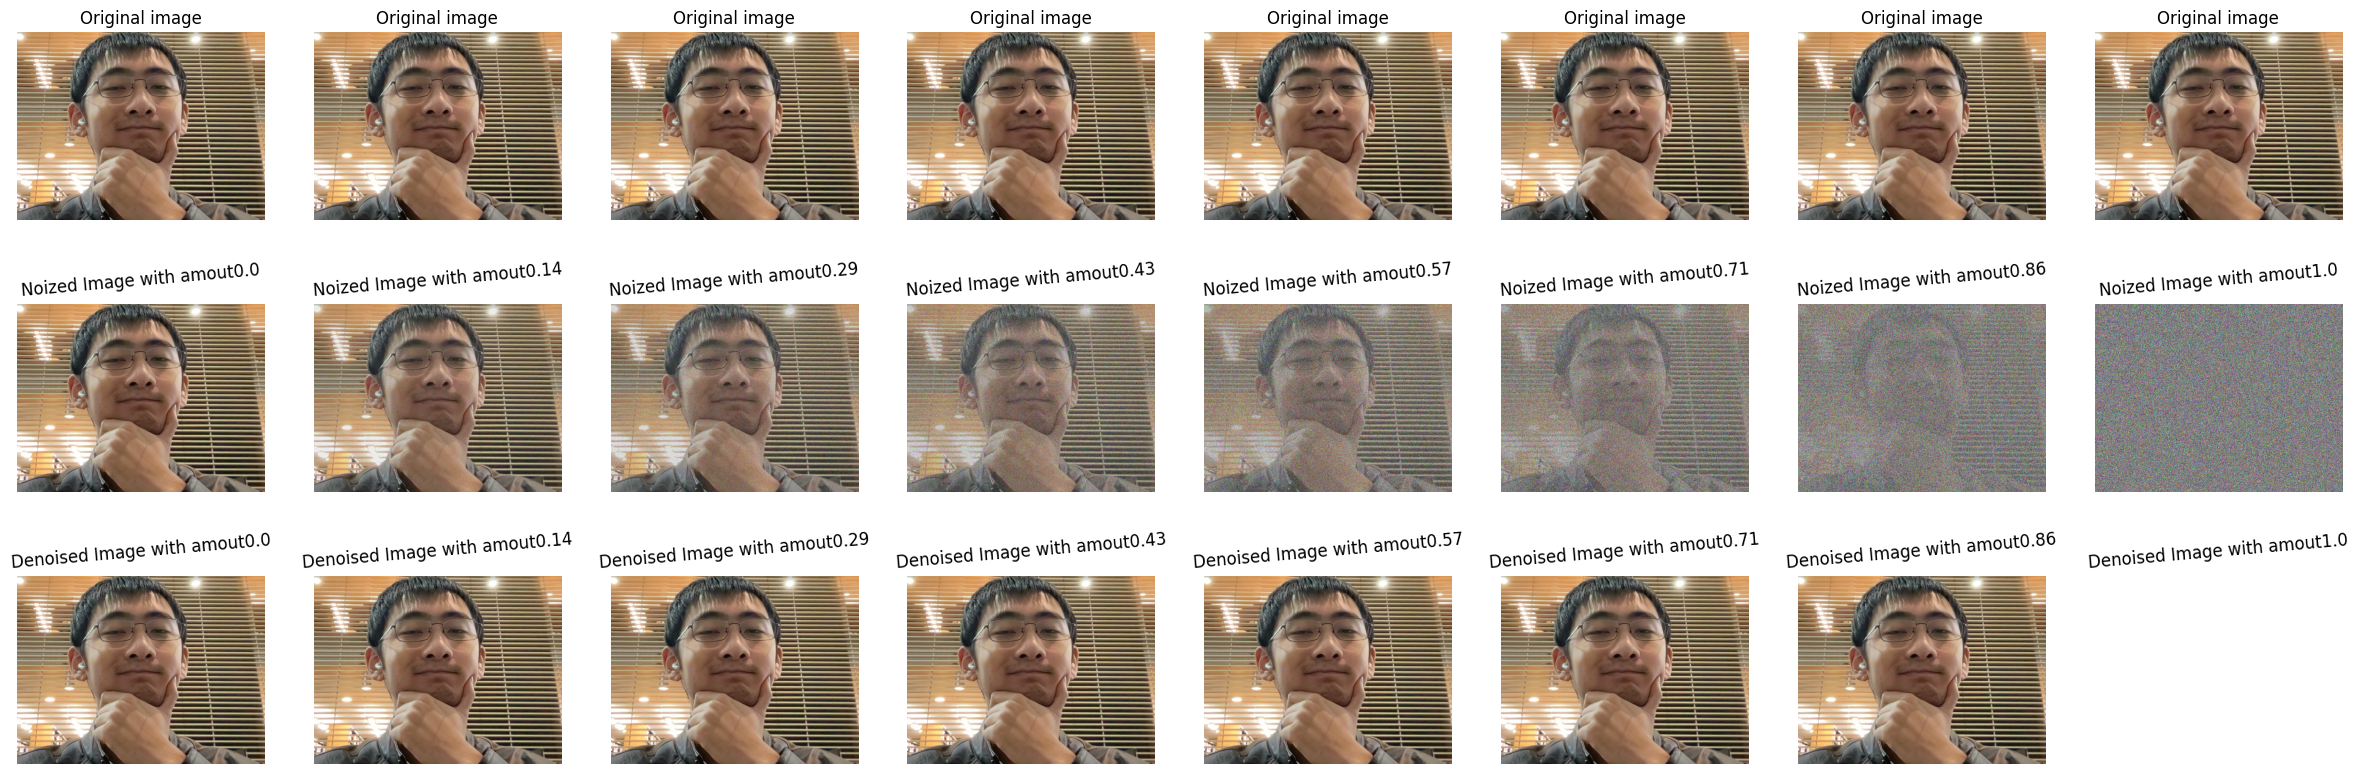

In [8]:

denoised_img = denoise(noised_img, amount, noise)

plt.figure(figsize=(30, 10))
for i in range(0, 24):
    plt.subplot(3, 8, i+1)
    if i < 8:
        plt.imshow(image_batch[i])
        plt.title("Original image")
        plt.axis('off')
    elif i >=8 and i < 16:
        plt.imshow(noised_img[i-8])
        plt.title("Noized Image with amout" + str(round(amount[i-8].item(), 2)), rotation=5)
        plt.axis('off')
    else:
        plt.imshow(denoised_img[i-16])
        plt.title("Denoised Image with amout" + str(round(amount[i-16].item(), 2)), rotation=5)
        plt.axis('off')

# Now Lets Scale it up to basic encoder and decoder network

MNIST

In [9]:
dataset = torchvision.datasets.MNIST(
    root="mnist/", train=True, download=True, transform=torchvision.transforms.ToTensor()
)

train_dataloader = DataLoader(dataset, batch_size=8, shuffle=True)

Input shape: torch.Size([8, 1, 28, 28])
Labels: tensor([2, 8, 6, 6, 4, 4, 4, 7])


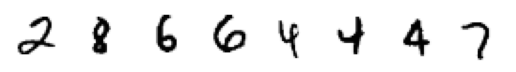

In [10]:
x, y = next(iter(train_dataloader))
print("Input shape:", x.shape)
print("Labels:", y)


images = x.squeeze(1)  # Shape becomes [8, 28, 28]
# Plot each image
batch_size = images.shape[0]
for i in range(batch_size):
    plt.subplot(1, batch_size, i + 1)
    plt.imshow(images[i].cpu().numpy(), cmap="Greys")  # Convert to numpy and specify grayscale
    plt.axis('off')  # Optional: Turn off axis for cleaner display

# plt.imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

In [11]:
def add_noise(x, amount):
    noise = torch.rand_like(x)
    amount = amount.view(-1, 1, 1, 1)
    return x * (1 - amount) + noise * amount

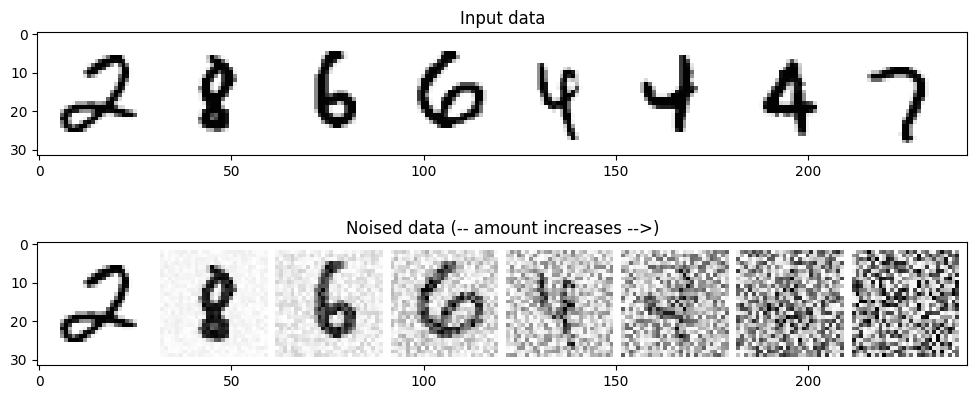

In [12]:
# Plotting the input data
fig, axs = plt.subplots(2, 1, figsize=(12, 5))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0], cmap="Greys")

# Adding noise
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
noised_x = add_noise(x, amount)

# Plotting the noised version
axs[1].set_title("Noised data (-- amount increases -->)")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0], cmap="Greys")

## UNet model

In [13]:
class CustomizedUNet(nn.Module):
    """A minimal UNet implementation with more down and up layers."""

    def __init__(self, in_channels=1, out_channels=1):
        super().__init__()
        self.down_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(in_channels, 32, kernel_size=5, padding=2),
                nn.Conv2d(32, 64, kernel_size=5, padding=2),
                nn.Conv2d(64, 128, kernel_size=5, padding=2),
                nn.Conv2d(128, 128, kernel_size=5, padding=2),
            ]
        )
        self.up_layers = torch.nn.ModuleList(
            [
                nn.Conv2d(128, 128, kernel_size=5, padding=2),
                nn.Conv2d(128 + 128, 64, kernel_size=5, padding=2),  # Note: Add channel from skip connection
                nn.Conv2d(64 + 64, 32, kernel_size=5, padding=2),    # Add channel from skip connection
                nn.Conv2d(32 + 32, out_channels, kernel_size=5, padding=2),  # Add channel from skip connection
            ]
        )
        self.act = nn.SiLU()  # The activation function
        self.downscale = nn.MaxPool2d(2)
        
        # Use Upsample with align_corners=True
        self.upscale = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)

    def forward(self, x):
        h = []  # Store skip connections
        
        # Down layers
        for i, l in enumerate(self.down_layers):
            x = self.act(l(x))  # Apply convolution + activation
            if i < len(self.down_layers) - 1:  # For all but the last down layer
                h.append(x)  # Store output for skip connection
                x = self.downscale(x)  # Downscale for the next layer

        # Up layers
        for i, l in enumerate(self.up_layers):
            if i > 0:  # For all except the first up layer
                x = self.upscale(x)  # Upsample
                # Ensure sizes are aligned for concatenation
                if x.shape[2:] != h[-1].shape[2:]:
                    x = torch.nn.functional.interpolate(x, size=h[-1].shape[2:], mode='bilinear', align_corners=True)
                x = torch.cat([x, h.pop()], dim=1)  # Concatenate skip connection
            x = self.act(l(x))  # Apply convolution + activation

        return x

In [14]:
net = CustomizedUNet()
x = torch.rand(8, 1, 28, 28)
net(x).shape

torch.Size([8, 1, 28, 28])

Finished epoch 0. Average loss for this epoch: 0.027545
Finished epoch 1. Average loss for this epoch: 0.020979
Finished epoch 2. Average loss for this epoch: 0.018916
Finished epoch 3. Average loss for this epoch: 0.018032


(0.0, 0.1)

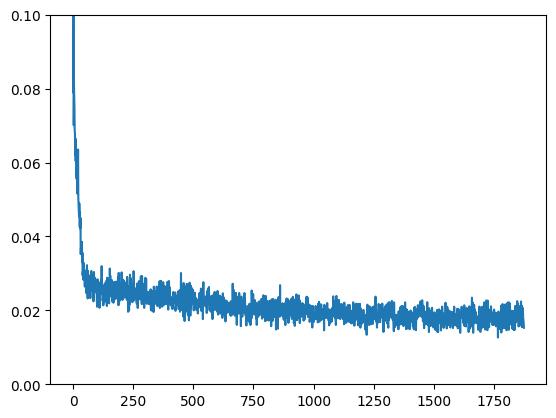

In [15]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 4

# Create the network
net = CustomizedUNet()
net.to(device)

# Our loss function
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # Pick random noise amounts
        noisy_x = add_noise(x, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x)

        # Calculate the loss
        loss = loss_fn(pred, x)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# View the loss curve
plt.plot(losses)
plt.ylim(0, 0.1)

## Lets get some images from the dataset and add some noise to them, then let the model to recover the original images

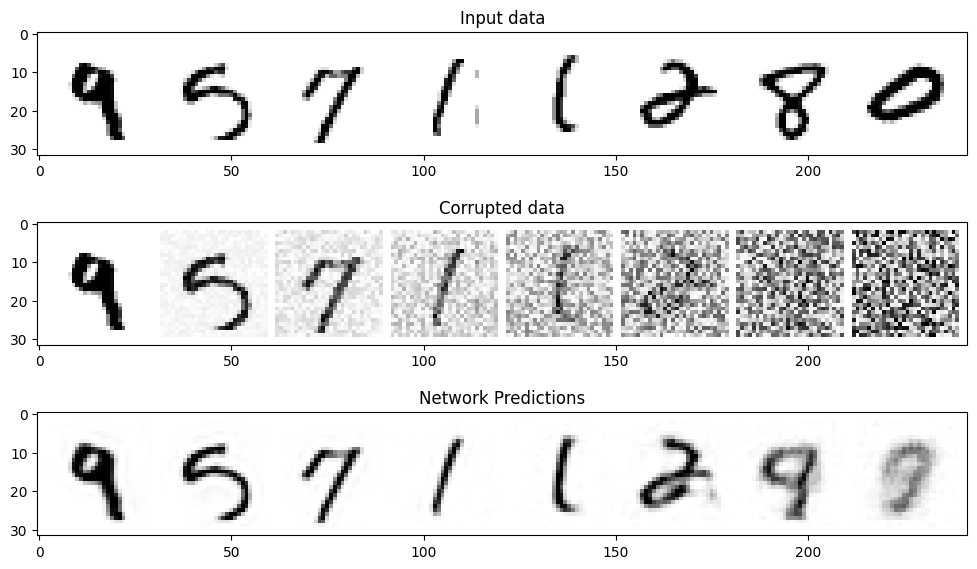

In [16]:
x, y = next(iter(train_dataloader))
x = x[:8]  # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
# amount = torch.full((x.shape[0],), 0.9)
noised_x = add_noise(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device)).detach().cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Noised data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys")

## Lets just substract some small amount of noise in each step

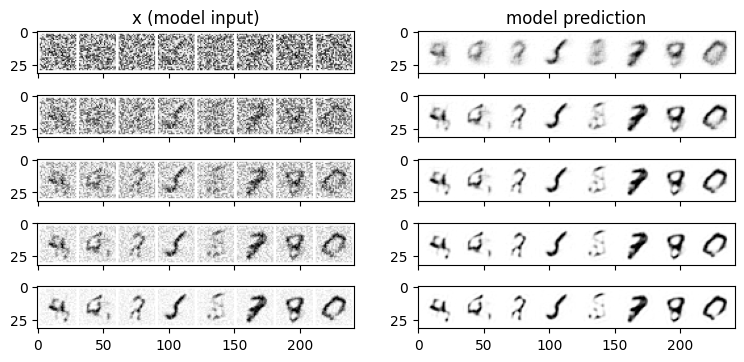

In [17]:
n_steps = 5
# x = torch.rand(8, 1, 28, 28).to(device)  # Start from random
amount = amount = torch.full((x.shape[0],), 0.9)
noised_x = add_noise(x, amount)
step_history = [noised_x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():  # No need to track gradients during inference
        pred = net(noised_x.to(device))  # Predict the denoised x0
    pred_output_history.append(pred.detach().cpu())  # Store model output for plotting
    mix_factor = 1 / (n_steps - i)  # How much we move towards the prediction
    noised_x = noised_x * (1 - mix_factor) + pred.cpu() * mix_factor  # Move part of the way there
    step_history.append(noised_x.detach().cpu())  # Store step for plotting

fig, axs = plt.subplots(n_steps, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")
for i in range(n_steps):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys")
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap="Greys")

In [18]:
model = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)
# print(model)

In [19]:
print(model)

UNet2DModel(
  (conv_in): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (time_proj): Timesteps()
  (time_embedding): TimestepEmbedding(
    (linear_1): Linear(in_features=32, out_features=128, bias=True)
    (act): SiLU()
    (linear_2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down_blocks): ModuleList(
    (0): DownBlock2D(
      (resnets): ModuleList(
        (0-1): 2 x ResnetBlock2D(
          (norm1): GroupNorm(32, 32, eps=1e-05, affine=True)
          (conv1): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (time_emb_proj): Linear(in_features=128, out_features=32, bias=True)
          (norm2): GroupNorm(32, 32, eps=1e-05, affine=True)
          (dropout): Dropout(p=0.0, inplace=False)
          (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (nonlinearity): SiLU()
        )
      )
      (downsamplers): ModuleList(
        (0): Downsample2D(
          (conv): Conv2d(32, 32, ker

Finished epoch 0. Average loss for this epoch: 0.018141
Finished epoch 1. Average loss for this epoch: 0.012574
Finished epoch 2. Average loss for this epoch: 0.011586


Text(0.5, 1.0, 'Loss over time')

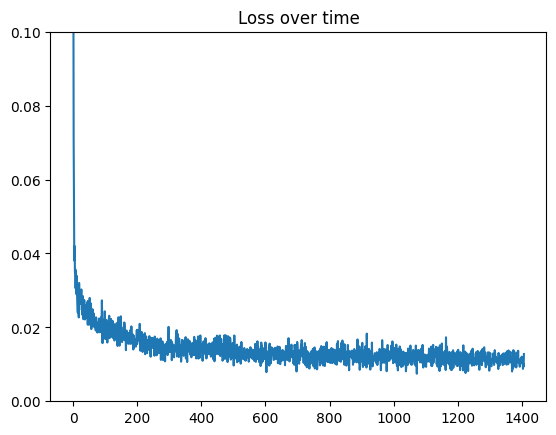

In [20]:
# Dataloader (you can mess with batch size)
batch_size = 128
train_dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

# How many runs through the data should we do?
n_epochs = 3

# Create the network
net = UNet2DModel(
    sample_size=28,  # the target image resolution
    in_channels=1,  # the number of input channels, 3 for RGB images
    out_channels=1,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(32, 64, 64),  # Roughly matching our basic unet example
    down_block_types=(
        "DownBlock2D",  # a regular ResNet downsampling block
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D",  # a regular ResNet upsampling block
    ),
)  # <<<
net.to(device)

# Our loss finction
loss_fn = nn.MSELoss()

# The optimizer
opt = torch.optim.Adam(net.parameters(), lr=1e-3)

# Keeping a record of the losses for later viewing
losses = []

# The training loop
for epoch in range(n_epochs):

    for x, y in train_dataloader:

        # Get some data and prepare the corrupted version
        x = x.to(device)  # Data on the GPU
        noise_amount = torch.rand(x.shape[0]).to(device)  # Pick random noise amounts
        noisy_x = add_noise(x, noise_amount)  # Create our noisy x

        # Get the model prediction
        pred = net(noisy_x, 0).sample  # <<< Using timestep 0 always, adding .sample

        # Calculate the loss
        loss = loss_fn(pred, x)  # How close is the output to the true 'clean' x?

        # Backprop and update the params:
        opt.zero_grad()
        loss.backward()
        opt.step()

        # Store the loss for later
        losses.append(loss.item())

    # Print our the average of the loss values for this epoch:
    avg_loss = sum(losses[-len(train_dataloader) :]) / len(train_dataloader)
    print(f"Finished epoch {epoch}. Average loss for this epoch: {avg_loss:05f}")

# Plot the Loss
plt.plot(losses)
plt.ylim(0, 0.1)
plt.title("Loss over time")

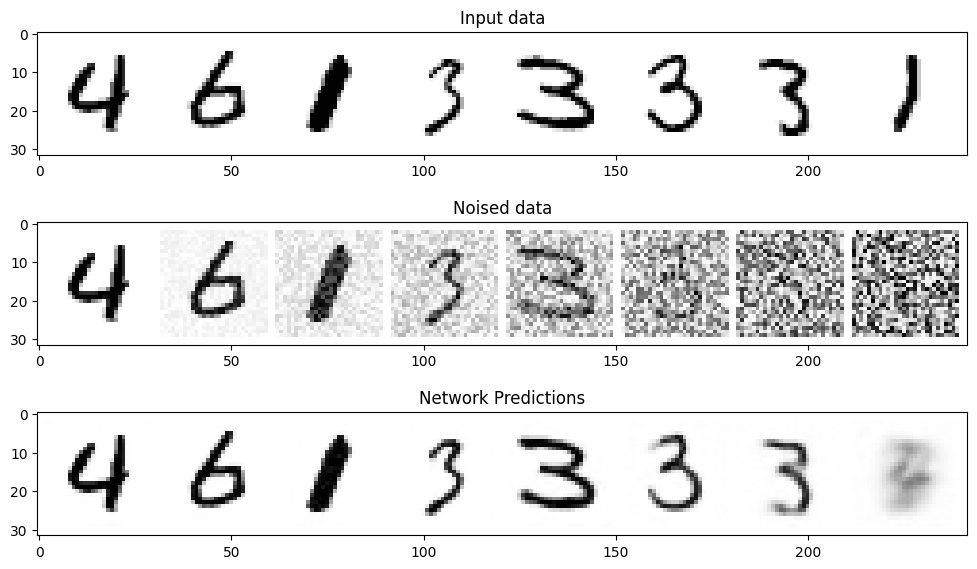

In [24]:
x, y = next(iter(train_dataloader))
x = x[:8]  # Only using the first 8 for easy plotting

# Corrupt with a range of amounts
amount = torch.linspace(0, 1, x.shape[0])  # Left to right -> more corruption
# amount = torch.full((x.shape[0],), 0.9)
noised_x = add_noise(x, amount)

# Get the model predictions
with torch.no_grad():
    preds = net(noised_x.to(device), 0).sample.cpu()

# Plot
fig, axs = plt.subplots(3, 1, figsize=(12, 7))
axs[0].set_title("Input data")
axs[0].imshow(torchvision.utils.make_grid(x)[0].clip(0, 1), cmap="Greys")
axs[1].set_title("Noised data")
axs[1].imshow(torchvision.utils.make_grid(noised_x)[0].clip(0, 1), cmap="Greys")
axs[2].set_title("Network Predictions")
axs[2].imshow(torchvision.utils.make_grid(preds)[0].clip(0, 1), cmap="Greys")


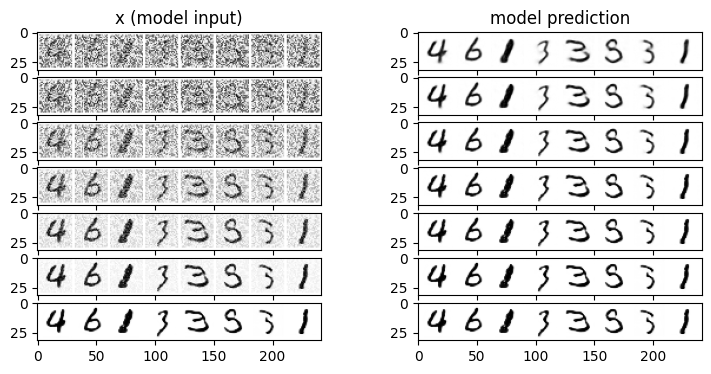

In [37]:
n_steps = 50  # Increased to have more steps for 10-step history saving
amount = torch.full((x.shape[0],), 0.8)
noised_x = add_noise(x, amount)
step_history = [noised_x.detach().cpu()]
pred_output_history = []

for i in range(n_steps):
    with torch.no_grad():  # No need to track gradients during inference
        pred = net(noised_x.to(device), 0)  # Predict the denoised x0

    mix_factor = 1 / (n_steps - i)  # How much we move towards the prediction
    noised_x = noised_x * (1 - mix_factor) + pred.sample.cpu() * mix_factor  # Move part of the way there

    # Store history every 10 steps (including the last step)
    if i % 10 == 0 or i == n_steps - 1:
        step_history.append(noised_x.detach().cpu())  # Store step for plotting
        pred_output_history.append(pred.sample.cpu())  # Store model output for plotting
pred_output_history.append(pred.sample.cpu())
# Update the visualization to match the new history recording logic
n_rows = len(step_history)  # Number of rows corresponds to how many times we saved history
fig, axs = plt.subplots(n_rows, 2, figsize=(9, 4), sharex=True)
axs[0, 0].set_title("x (model input)")
axs[0, 1].set_title("model prediction")

for i in range(n_rows):
    axs[i, 0].imshow(torchvision.utils.make_grid(step_history[i])[0].clip(0, 1), cmap="Greys")
    axs[i, 1].imshow(torchvision.utils.make_grid(pred_output_history[i])[0].clip(0, 1), cmap="Greys")


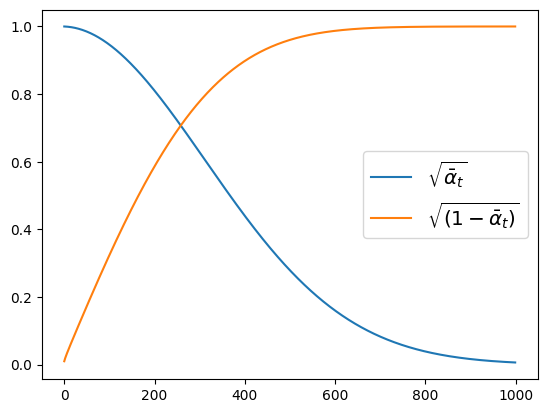

In [60]:
noise_scheduler = DDPMScheduler(num_train_timesteps=1000)
plt.plot(noise_scheduler.alphas_cumprod.cpu() ** 0.5, label=r"${\sqrt{\bar{\alpha}_t}}$")
plt.plot((1 - noise_scheduler.alphas_cumprod.cpu()) ** 0.5, label=r"$\sqrt{(1 - \bar{\alpha}_t)}$")
plt.legend(fontsize="x-large")